In [1]:
## import required dependencies ##

import numpy as np
import pandas as pd
import numexpr as ne
import scipy as sp
import os
from tqdm import tqdm

## extra  libraries for graphing ##

import sys
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
##define the functions for using in running FaIR ##

def return_gas_namelist_e():
    
    gas_namelist = ['bc',
                    'bc|aci',
                    'bc|bc_on_snow',
                    'c2f6',
                    'c3f8',
                    'c4f10',
                    'c5f12',
                    'c6f14',
                    'c7f16',
                    'c8f18',
                    'c_c4f8',
                    'carbon_dioxide',
                    'carbon_tetrachloride',
                    'carbon_tetrachloride|o3',
                    'cf4',
                    'cfc11',
                    'cfc113',
                    'cfc113|o3',
                    'cfc114',
                    'cfc114|o3',
                    'cfc115',
                    'cfc115|o3',
                    'cfc11|o3',
                    'cfc12',
                    'cfc12|o3',
                    'ch2cl2',
                    'ch2cl2|o3',
                    'ch3ccl3',
                    'ch3ccl3|o3',
                    'chcl3',
                    'chcl3|o3',
                    'co',
                    'co|o3',
                    'halon1202',
                    'halon1202|o3',
                    'halon1211',
                    'halon1211|o3',
                    'halon1301',
                    'halon1301|o3',
                    'halon2402',
                    'halon2402|o3',
                    'hcfc141b',
                    'hcfc141b|o3',
                    'hcfc142b',
                    'hcfc142b|o3',
                    'hcfc22',
                    'hcfc22|o3',
                    'hfc125',
                    'hfc134a',
                    'hfc143a',
                    'hfc152a',
                    'hfc227ea',
                    'hfc23',
                    'hfc236fa',
                    'hfc245fa',
                    'hfc32',
                    'hfc365mfc',
                    'hfc4310mee',
                    'methane',
                    'methane|strat_h2o',
                    'methane|o3',
                    'methyl_bromide',
                    'methyl_bromide|o3',
                    'methyl_chloride',
                    'methyl_chloride|o3',
                    'nf3',
                    'nh3',
                    'nitrous_oxide',
                    'nitrous_oxide|o3',
                    'nmvoc',
                    'nmvoc|o3',
                    'nox',
                    'nox_avi',
                    'nox_avi|contrails',
                    'nox|o3',
                    'oc',
                    'oc|aci',
                    'sf6',
                    'so2',
                    'so2f2',
                    'so2|aci'
                   ]
    
    return gas_namelist

def get_gas_parameter_defaults_e(choose_gases=return_gas_namelist_e()):

# this is the file that contains all the default parameters for running FaIR #
    
    CHOOSE_params = pd.read_csv(("Complete_gas_cycle_params.csv"),header=[0,1],index_col=0).reindex(choose_gases,axis=1,level=1)

    return CHOOSE_params

def get_thermal_parameter_defaults_e(TCR=1.79,RWF=0.552,F_2x=3.759):

# these parameters are taken from the 2021 paper Leach et al: https://gmd.copernicus.org/articles/14/3007/2021/gmd-14-3007-2021.pdf #

    d1 = 0.903
    d2 = 7.92
    d3 = 355
    q1 = 0.180
    ECS = TCR/RWF

    v1 = (1-(d1/69.66) * (1-np.exp(-69.66/d1)) )
    v2 = (1-(d2/69.66) * (1-np.exp(-69.66/d2)) )
    v3 = (1-(d3/69.66) * (1-np.exp(-69.66/d3)) )

    q3 = (((TCR/F_2x) - q1*(v1-v2) - (ECS/F_2x)*v2) / (v3-v2))
    q2 = (ECS/F_2x - q1 -  q3)

    df = pd.DataFrame([[d1,d2,d3],[q1,q2,q3]],
                      index=['d','q'],
                      columns=pd.MultiIndex.from_product([['default'],[1,2,3]])
                     )

    return df.apply(pd.to_numeric)

def calculate_alpha_e(G,G_A,cum_fgco2,r,g0,g1,iirf100_max = False):

# iirf100 is the average airborne fraction of the gases considered over a period of 100 years #
    
    iirf100_val = r[...,0] + r[...,1] * (G-G_A) + r[...,2] * cum_fgco2 + r[...,3] * G_A 
    
    if iirf100_max:
        
        if iirf100_val>iirf100_max:
            
            iirf100_val=iirf100_max

# alpha is the statedependent timescale adjustment factor; it scales the decay timescales of the gases considered, allowing for the effective sink from the atmosphere to change in strength over time #
    
    alpha_val = g0 * np.exp(iirf100_val / g1)

    return alpha_val

def step_forcing_e(pco2,PI_pco2,f):

    RF=np.zeros_like(pco2)

    for i in range(len(pco2)):

# the logarithmic, linear, and square root forcing components are calculated and then summed to find the total realtive forcing for each gas [i] #
        
        if (pco2[i]/PI_pco2) <= 0:
            
            logforc=0
        else:
            
            logforc=f[0]*np.log(pco2[i]/PI_pco2)

        linforc = f[1] * (pco2[i] - PI_pco2)
    
        if pco2[i]<0:
            
           sqrtforc = f[2] * (np.sqrt(0) - np.sqrt(PI_pco2))
            
        else:
            
           sqrtforc = f[2] * (np.sqrt(pco2[i]) - np.sqrt(PI_pco2))
            
        RF[i] = logforc + linforc + sqrtforc
        
    return RF


def return_empty_emissions_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1, gases_in = return_gas_namelist_e()):

# formatting a pandas dataframe that is empty, ready to be filled with emissions #
    
    if type(df_to_copy)==pd.core.frame.DataFrame:
        
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([gases_in],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        
    else:

        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep),
                          columns=pd.MultiIndex.from_product([gases_in],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

def return_empty_forcing_e(df_to_copy=False, start_year=1765, end_year=2500, timestep=1):

# formatting a pandas dataframe that is empty, ready to be filled with forcing #
    
    if type(df_to_copy)==pd.core.frame.DataFrame:
        
        df = pd.DataFrame(index = df_to_copy.index,
                          columns=pd.MultiIndex.from_product([['pco2']],
                                                             names=['Variable']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        
    else:
        
        df = pd.DataFrame(index=np.arange(start_year,end_year+1,timestep),
                          columns=pd.MultiIndex.from_product([['pco2']],
                                                             names=['Gas']
                                                            )
                         ).fillna(0).apply(pd.to_numeric)
        df.index.rename('Year',inplace=True)

    return df

def step_fgco2_e(S_old,F,q,d,dt=1):

    decay_factor = np.exp(-dt/d)
    S_new = q * F['pco2'] * (1 - decay_factor) + S_old * decay_factor # if not pandas dataframe will need to not reference by title 'pco2'
    fgco2 = np.sum((S_old + S_new)/2)

    return S_new,fgco2

def step_concentration_e(R_old,G_A_old,E,alpha,a,tau,PI_conc,emis2conc,dt=1):

    R_new=np.zeros_like(a)
    
    for x in range(len(a[0])): # number of boxes, 4 at the moment, but this needs to be the same as tau
        
        for i in range(len(alpha)): # number of gases
            
            decay_rate = dt/(alpha[i]*tau[i,x])
            decay_factor = np.exp(-decay_rate)
            R_new[i,x] = E[i] * a[i,x] / decay_rate * ( 1. - decay_factor ) + R_old[i,x] * decay_factor # there shouldn't be a dt in the first decay rate
   
    G_A = np.sum(R_new, axis=-1)
    C = PI_conc + emis2conc * (G_A + G_A_old) / 2
    
    return C,R_new,G_A

def unstep_concentration_e(R_old,G_A,alpha,a,tau,dt=1):

    decay_rate = dt/(alpha*tau)
    decay_factor = np.exp(-decay_rate)
    E = (( G_A - np.sum(R_old *decay_factor,axis=-1) ) / np.sum( a / decay_rate * ( 1. - decay_factor ), axis=-1 )) # err maybe spotted : changing value of E each cycle?
    R_new = E * a / decay_rate * ( 1. - decay_factor ) + R_old * decay_factor # there shouldn't be a dt in the first decay rate

    return E,R_new

def invert_carbon_cycle_prescribed_cum_fgco2(C,cum_fgco2,a,tau,r,PI_conc,emis2conc):

   g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1)
   g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 )

   diagnosed_emissions = np.zeros(C.size)
   alpha = np.zeros(C.size)
   G_A = (np.array([np.mean(C[i:i+2]) for i in np.arange(C.size)])-PI_conc)/emis2conc
   G_A[-1]=2*G_A[-1]-G_A[-2]

   alpha[0] = calculate_alpha_e(G=0,G_A=0,cum_fgco2=0,r=r,g0=g0,g1=g1)
   diagnosed_emissions[0],R = unstep_concentration_e(R_old=np.zeros_like(a),G_A=G_A[0],alpha=alpha[0,np.newaxis],a=a,tau=tau)
   for t in np.arange(1,C.size):
       G = np.sum(diagnosed_emissions)
       alpha[t] = calculate_alpha_e(G=G,G_A=G_A[t-1],cum_fgco2=cum_fgco2[t-1],r=r,g0=g0,g1=g1)
       diagnosed_emissions[t],R = unstep_concentration_e(R_old=R,G_A=G_A[t],alpha=alpha[t,np.newaxis],a=a,tau=tau)

   return pd.Series(index=np.arange(C.size),data=diagnosed_emissions)


In [3]:
def run_FaIR_ocean (emissions_in=False,
             ext_forcing=False,
             concentrations_in=False, 
             gas_parameters=get_gas_parameter_defaults_e(),
             thermal_parameters=get_thermal_parameter_defaults_e(),
             iirf100_max=False):


    if emissions_in is False: 
        concentration_driven = True
        emissions_in = pd.DataFrame().reindex_like(concentrations_in)
        ext_forcing = return_empty_forcing_e(df_to_copy=concentrations_in)
        time_index = concentrations_in.index
    else: 
        concentration_driven=False
        ext_forcing = return_empty_forcing_e(df_to_copy=emissions_in)
        time_index = emissions_in.index
    
    [(gas_set_names),(thermal_set_names)]=[(list(x)) for x in [gas_parameters.columns.levels[0],thermal_parameters.columns.levels[0]]]

    gas_names = [x for x in gas_parameters.columns.levels[1] if '|' not in x]
    n_gas = len(gas_names)
    n_forc,forc_names = gas_parameters.columns.levels[1].size,list(gas_parameters.columns.levels[1])
    n_year = len(time_index)

    timestep = np.append(np.diff(time_index),np.diff(time_index)[-1]) ## finds the discrete difference between each timestep

    a,tau,r,PI_conc,emis2conc=[gas_parameters.loc[x].values.T for x in [['a1','a2','a3','a4'],['tau1','tau2','tau3','tau4'],['r0','rC','rT','rA'],'PI_conc','emis2conc']]
    d,q = [thermal_parameters.loc[x].values.T for x in ['d','q']]
    f = [4.57,  0. ,   0.086] # forcing coefficients (log, lin, sqrt)

    g1 = np.sum( a * tau * ( 1. - ( 1. + 100/tau ) * np.exp(-100/tau) ), axis=-1 )
    g0 = np.exp( -1 * np.sum( a * tau * ( 1. - np.exp(-100/tau) ) , axis=-1) / g1 ) 

    C = np.empty((n_gas,n_year))
    RF = np.empty((n_forc,n_year))
    fgco2 = np.empty((n_year))
    alpha = np.empty((n_gas,n_year))
    alpha[...,0] = calculate_alpha_e(G=0,G_A=0,cum_fgco2=0,r=r,g0=g0,g1=g1)
    
    names_list = [gas_set_names,thermal_set_names,gas_names]
    names_titles = ['Gas cycle set','Thermal set','Gas name']
    forc_names_list = [gas_set_names,thermal_set_names,forc_names]
    forc_names_titles = ['Gas cycle set','Thermal set','Forcing component']

    if concentration_driven:

        diagnosed_emissions = np.zeros((n_gas,n_year))

        R_old = np.zeros((concentrations_in.iloc[0].size,a.size))
        
        C[:] = concentrations_in.T

        pco2=C

        PI_pco2=280.

        G_A = np.zeros_like(C)
        
        G_A[...,:-1] = concentrations_in.rolling(2).mean().dropna().values.T.reshape(n_gas,n_year-1)
        
        G_A[...,-1] = G_A[...,-2] + (C[...,-1]-C[...,-2]) #same as axis of summation, back to front
        
        G_A = (G_A-PI_conc)/emis2conc
        
        RF[...,0] = step_forcing_e(pco2=pco2[...,0],PI_pco2=PI_pco2,f=f) ## here i am chaning the formatting of RF to be variable over time, as for emissions inputs
        
        diagnosed_emissions[...,0],R = unstep_concentration_e(R_old=R_old,G_A=G_A[...,0],alpha=alpha[...,0,np.newaxis],a=a,tau=tau,dt=timestep[0])
        
        S,fgco2[...,0] = step_fgco2_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing.iloc[0],q=q,d=d,dt=timestep[0])
        
        for t in tqdm(np.arange(1,n_year),unit=' timestep'):
            
            G = np.sum(diagnosed_emissions,axis=-1)
            
            alpha[...,t] = calculate_alpha_e(G=G,G_A=G_A[...,t-1],cum_fgco2=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)

            diagnosed_emissions[...,t],R = unstep_concentration_e(R_old=R,G_A=G_A[...,t],alpha=alpha[...,t,np.newaxis],a=a,tau=tau,dt=timestep[t])

            RF[...,t] = step_forcing_e(pco2=pco2[...,t],PI_pco2=PI_pco2,f=f)
            
            S,fgco2[...,t] = step_fgco2_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing.iloc[t],q=q,d=d,dt=timestep[t])

        C_out = concentrations_in.copy()
        
        E_out = pd.DataFrame(np.moveaxis(diagnosed_emissions,-1,0).reshape(diagnosed_emissions.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))

    if not concentration_driven:
        
        G = np.cumsum(emissions_in)

        R_old = np.zeros((emissions_in.iloc[0].size,4))
    
        C[...,0],R,G_A = step_concentration_e(R_old = R_old,G_A_old = 0,alpha=alpha[...,0,np.newaxis],E=emissions_in.iloc[0],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[0])
                
        RF[...,0] = step_forcing_e(pco2=pco2[...,0],PI_pco2=PI_pco2,f=f)
        
        S,T[...,0] = step_temperature_e(S_old=0,F=np.sum(RF[...,0],axis=-1)[...,np.newaxis]+ext_forcing.iloc[0],q=q,d=d,dt=timestep[0])

        for t in tqdm(np.arange(1,n_year),unit=' timestep'):
            
            alpha[...,t] = calculate_alpha_e(G=G.iloc[t-1],G_A=G_A,T=np.sum(S,axis=-1)[...,np.newaxis],r=r,g0=g0,g1=g1)
            
            C[...,t],R,G_A = step_concentration_e(R_old = R,G_A_old=G_A,alpha=alpha[...,t,np.newaxis],E=emissions_in.iloc[t],a=a,tau=tau,PI_conc=PI_conc,emis2conc=emis2conc[...,0],dt=timestep[t])
            
            RF[...,t] = step_forcing_e(C=C[...,t],PI_conc=PI_conc,f=f)
            
            S,T[...,t] = step_fgco2_e(S_old=S,F=np.sum(RF[...,t],axis=-1)[...,np.newaxis]+ext_forcing.iloc[t],q=q,d=d,dt=timestep[t])

        C_out = pd.DataFrame(np.moveaxis(C,-1,0).reshape(C.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
        
        E_out = emissions_in.copy()

    cum_fgco2=np.cumsum(fgco2)

    inverted_carbon_cycle_emissions = np.empty((n_gas,n_year))

    inverted_carbon_cycle_emissions = invert_carbon_cycle_prescribed_cum_fgco2(C_out,cum_fgco2,a,tau,r,PI_conc,emis2conc)

    ext_forcing = ext_forcing.T
    RF = np.concatenate((RF,ext_forcing),axis=0) #stuck together like stacks of paper
    RF = np.concatenate((RF,np.sum(RF,axis=0)[...,np.newaxis,:]),axis=0) #total is total of co2 + methane + external for each timestep, is this what we wanted?
    
    alpha_out = pd.DataFrame(np.moveaxis(alpha,-1,0).reshape(alpha.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))
    RF_out = pd.DataFrame(np.moveaxis(RF,-1,0).reshape(RF.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product([x+['External','Total']*(x==forc_names_list[-1]) for x in forc_names_list],names=forc_names_titles))
    cum_fgco2_out = pd.DataFrame(np.moveaxis(cum_fgco2,-1,0).reshape(cum_fgco2.shape[-1],-1),index = time_index,columns=pd.MultiIndex.from_product(names_list[:-1],names=names_titles[:-1]))
    inverted_carbon_cycle_emissions_out = pd.DataFrame(inverted_carbon_cycle_emissions, index = time_index,columns=pd.MultiIndex.from_product(names_list,names=names_titles))


    out_dict = {'C_e':C_out, \
                'RF_pco2_e':RF_out, \
                'cum_fgco2_e':cum_fgco2_out, \
                'alpha_e':alpha_out, \
                'Emissions_e':E_out , \
                'gas_parameters_e':gas_parameters , \
                'thermal_parameters_e':thermal_parameters, \
                'inverted_carbon_cycle_emissions_e': inverted_carbon_cycle_emissions_out}

    for axis in [x for x in list(out_dict.keys())[:-2] if type(x)==pd.core.frame.DataFrame]:
        out_dict[axis].index = out_dict[axis].index.rename('Year')

    return out_dict


/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_4240/2445042524.py:188: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0).apply(pd.to_numeric)
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_4240/4270796739.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '280.78000000000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  concs_in.loc[1900+i, ('carbon_dioxide')]=concs_in.loc[1900+i-1, ('carbon_dioxide')]*1.01
/var/folders/dd/n_9wp4x11tn45bzqgcwvt_pr0000gp/T/ipykernel_4240/2445042524.py:203: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Ca

Text(0, 0.5, 'RF_pco2_e')

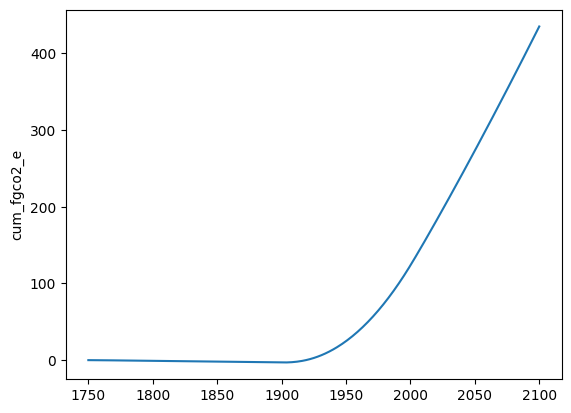

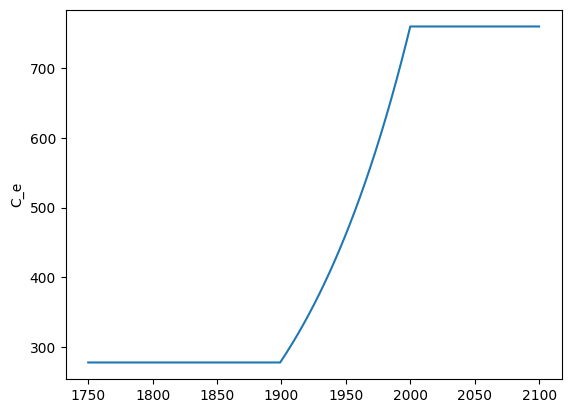

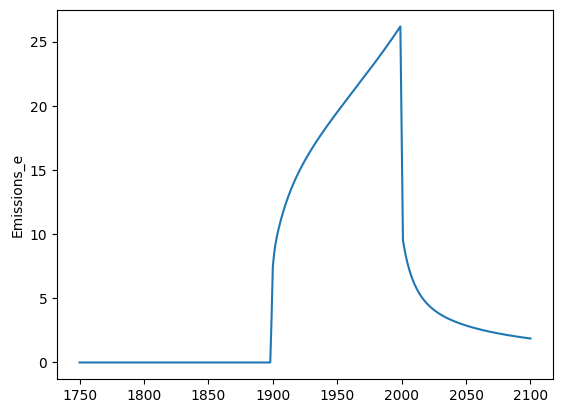

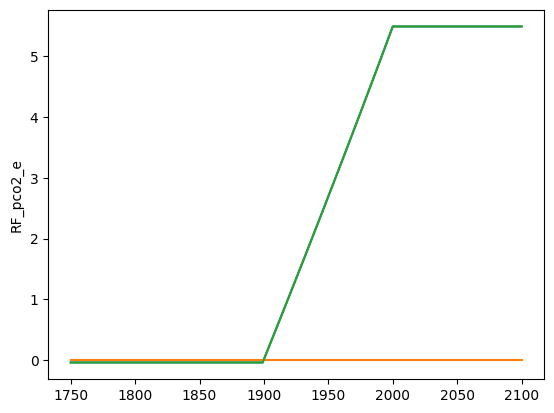

In [4]:
concs_in = return_empty_emissions_e(start_year=1750, end_year=2100, gases_in=['carbon_dioxide'])
concs_in.loc[1750:1900,('carbon_dioxide')] = 278. 
for i in range(len(concs_in)-1900+1750-100):
    concs_in.loc[1900+i, ('carbon_dioxide')]=concs_in.loc[1900+i-1, ('carbon_dioxide')]*1.01

concs_in.loc[2001:,('carbon_dioxide')] += concs_in.loc[2000,('carbon_dioxide')].values

gas_params = get_gas_parameter_defaults_e(choose_gases=['carbon_dioxide'])
therm_params = get_thermal_parameter_defaults_e()

out = run_FaIR_ocean(concentrations_in=concs_in, gas_parameters=gas_params, thermal_parameters=therm_params)
plt.plot(out['cum_fgco2_e'])
plt.ylabel("cum_fgco2_e")
plt.figure()
plt.plot(out['C_e'])
plt.ylabel("C_e")
plt.figure()
plt.plot(out['Emissions_e'])
plt.ylabel("Emissions_e")
plt.figure()
plt.plot(out['RF_pco2_e'])
plt.ylabel("RF_pco2_e")